# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [2]:
# Uncomment and run if required
#!pip install torchvision accelerate

In [3]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
# if torch.cuda.is_available():
#     device = "cuda" # Use GPU if available
# elif torch.backends.mps.is_available():
#     device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

c:\Users\Senthil\Anaconda3\envs\dsi_participant\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_dataset = datasets.FashionMNIST(
                                    root="./data",          # where to store the dataset
                                    train=False,            # load test split
                                    download=True           # download if not already present
                                    )
test_loader = test_loader = DataLoader(
                                        dataset=test_dataset,
                                        batch_size=16,
                                        shuffle=True,
                                        collate_fn=collate_clip  # ensures CLIPProcessor is used
                                        )

If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

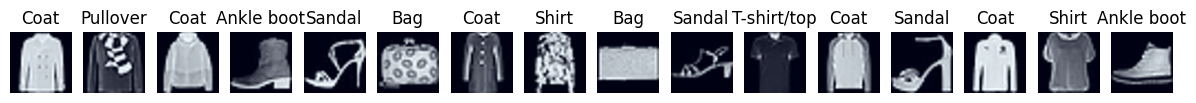

In [5]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [6]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [7]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = image_feats @ text_feats.T
    return similarity.numpy()

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    preds = np.argmax(similarity, axis=1)
    return preds

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

Zero-shot CLIP Accuracy: 62.40%


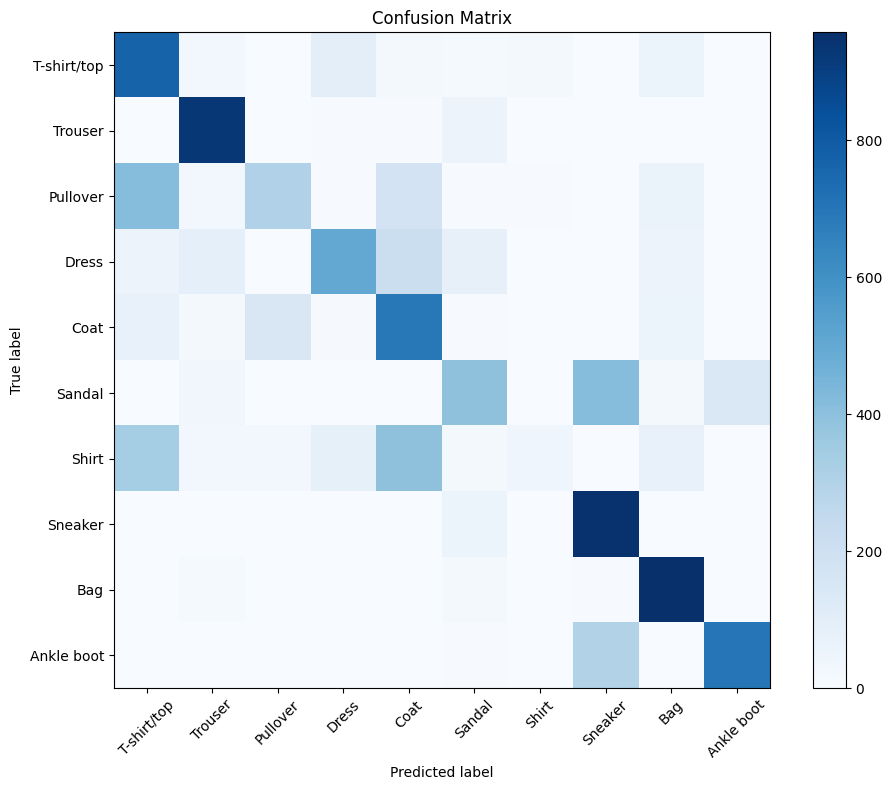

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
text_feats = get_text_embeddings(class_names)
y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)

    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image and text embeddings
    similarity = get_cosine_similarity(image_feats, text_feats)

    # Get predictions (indices of most similar text prompt)
    preds = get_predictions(similarity)

    # Save predictions and ground truth
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

# Report the accuracy of the predictions
y_true=np.array(y_true)
y_pred=np.array(y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP Accuracy: {acc * 100:.2f}%")

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

The CNN outperforms the zero-shot CLIP model. This could perhaps be because CNN is task-specific, it has been trained on the Fashion-MNIST training set and learned the nuances of the dataset.

Zero-shot CLIP has never seen this dataset during training. It only uses semantic knowledge from the text labels and pretraining on large web images. Confusion matrix shows misclassifications across visually similar or semantically close classes (e.g., “Pullover” vs “Shirt”, “Sandal” vs “Ankle boot”).

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Zero-shot CLIP Accuracy: 68.64%


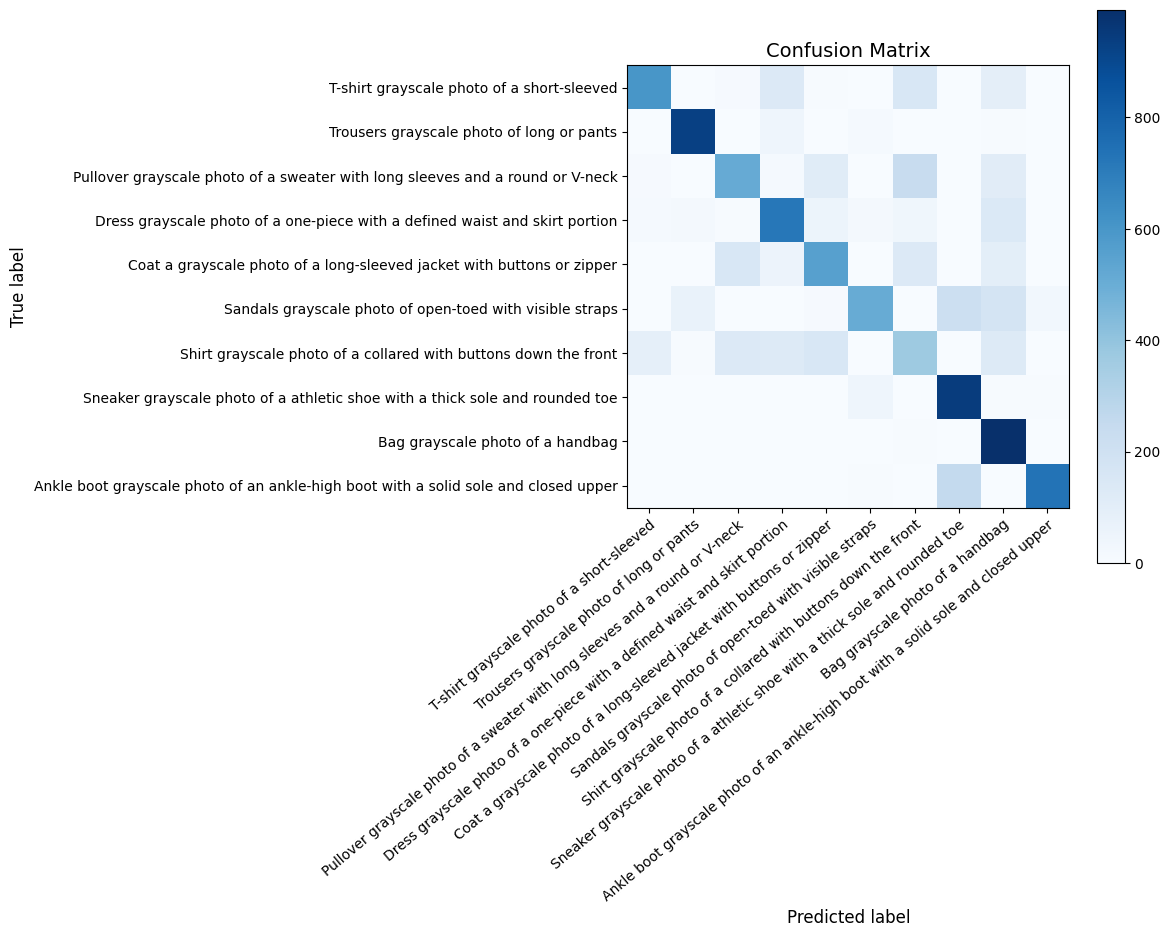

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
class_names = [
    "T-shirt grayscale photo of a short-sleeved, simple round neck, lightweight fabric",
    "Trousers grayscale photo of long or pants, straight or slim fit, covering both legs",
    "Pullover grayscale photo of a sweater with long sleeves and a round or V-neck, knitted texture",
    "Dress grayscale photo of a one-piece with a defined waist and skirt portion, medium to long length",
    "Coat a grayscale photo of a long-sleeved jacket with buttons or zipper, heavier outerwear",
    "Sandals grayscale photo of open-toed with visible straps, flat or low heel",
    "Shirt grayscale photo of a collared with buttons down the front, long sleeves",
    "Sneaker grayscale photo of a athletic shoe with a thick sole and rounded toe",
    "Bag grayscale photo of a handbag, shoulder bag, or tote with straps or handles",
    "Ankle boot grayscale photo of an ankle-high boot with a solid sole and closed upper"
]
text_feats = get_text_embeddings(class_names)
y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)

    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image and text embeddings
    similarity = get_cosine_similarity(image_feats, text_feats)

    # Get predictions (indices of most similar text prompt)
    preds = get_predictions(similarity)

    # Save predictions and ground truth
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

# Report the accuracy of the predictions
y_true=np.array(y_true)
y_pred=np.array(y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP Accuracy: {acc * 100:.2f}%")

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Title and color bar
    ax.set_title('Confusion Matrix', fontsize=14)
    fig.colorbar(im, ax=ax)

    # Tick marks and labels
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    # Use shorter class names for tick labels to avoid crowding
    short_labels = [name.split(",")[0] for name in class_names]  # keep only first phrase
    ax.set_xticklabels(short_labels, rotation=40, ha="right", fontsize=10)
    ax.set_yticklabels(short_labels, fontsize=10)

    # Axis labels
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12)

    # Add grid lines and better layout
    plt.setp(ax.get_xticklabels(), rotation=40, ha="right",
             rotation_mode="anchor")  # ensures proper alignment
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true, y_pred, class_names)

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

Introducing more detailed prompts led to a modest improvement in zero-shot classification accuracy — increasing from 62 % to 64 %. This suggests that the CLIP model benefits from richer textual context, as it can better associate visual structures in the images with the descriptive cues in the prompts. 

However, the improvement was marginal. This indicates that while CLIP’s text encoder does use semantic detail, its image embeddings for grayscale, low-resolution fashion items (like in Fashion-MNIST) may already be close to their textual counterparts’ cluster centers. The model likely relies heavily on overall shape and texture cues, which are somewhat limited in this dataset.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [10]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn

c:\Users\Senthil\Anaconda3\envs\dsi_participant\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Senthil\Anaconda3\envs\dsi_participant\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


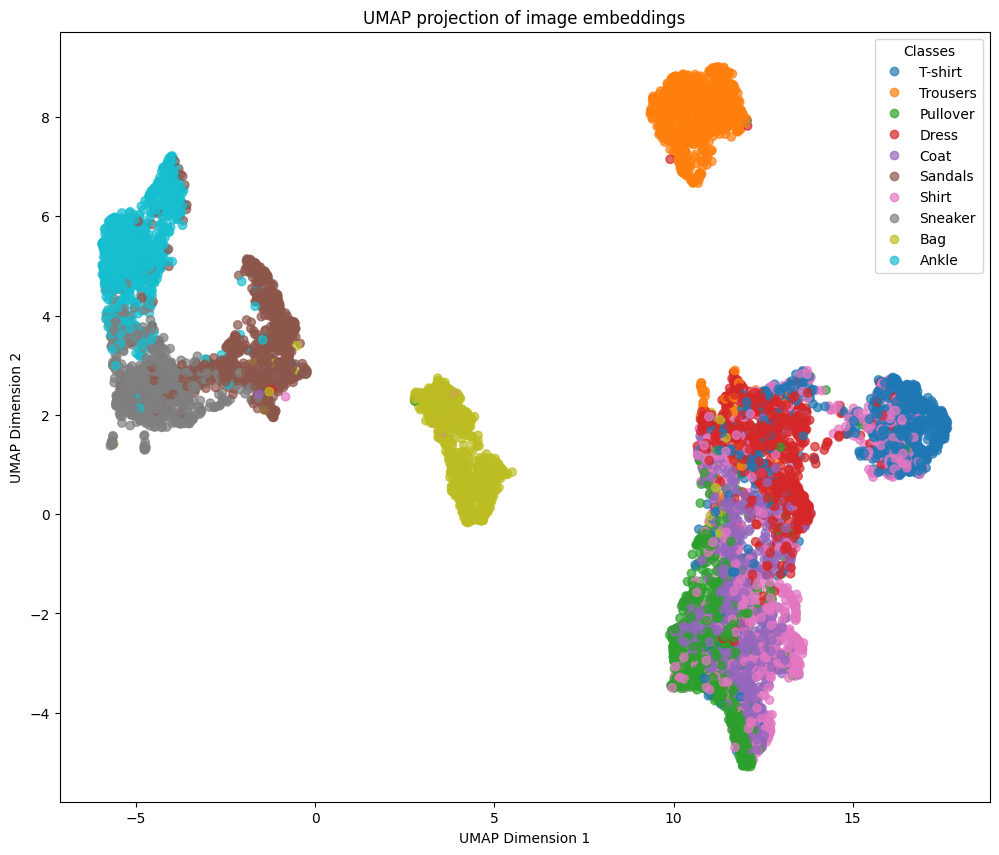

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import accuracy_score, confusion_matrix
# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    image_feats = get_image_embeddings(pixel_values)
    all_img_emb.append(image_feats.cpu().detach().numpy())
    all_labels.append(labels.cpu().numpy())
    
all_img_emb = np.vstack(all_img_emb)
all_labels  = np.hstack(all_labels)
# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap_model = UMAP(n_components=2, random_state=42)
img_emb_2d = umap_model.fit_transform(all_img_emb)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    img_emb_2d[:, 0], img_emb_2d[:, 1],
    c=all_labels, cmap='tab10', alpha=0.7
)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[c.split()[0] for c in class_names], 
           title="Classes", loc="best")
plt.title("UMAP projection of image embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

100%|██████████| 625/625 [22:14<00:00,  2.14s/it]


Zero-shot CLIP (Multi-Description) Accuracy: 66.14%


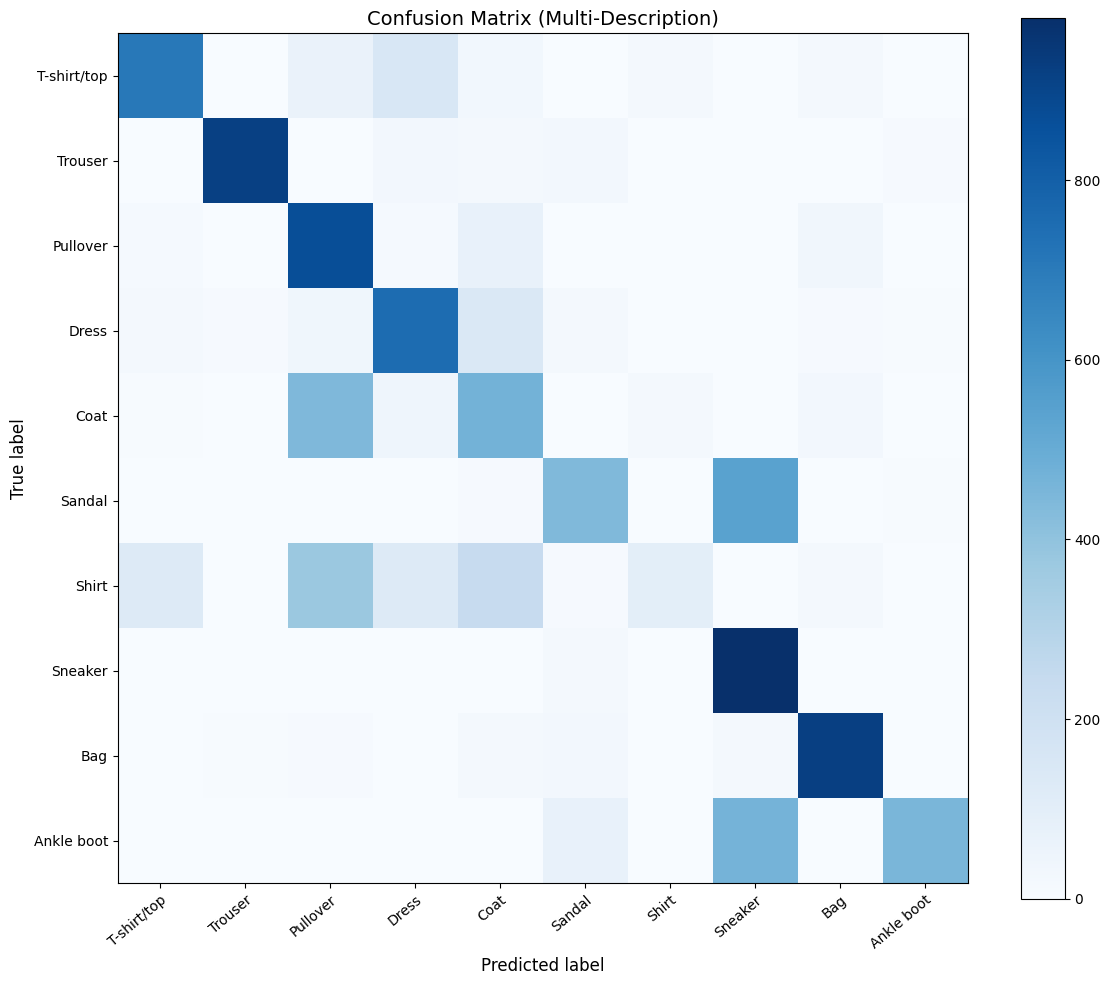

In [13]:
def get_text_embeddings_dict(class_prompts: dict[str, list[str]]) -> torch.Tensor:
    """
    Get mean-normalized text embeddings for multiple prompts per class using CLIP.

    Args:
        class_prompts (dict[str, list[str]]): 
            Dictionary mapping each class name to a list of descriptive prompts.
            Example:
                {
                    "T-shirt/top": ["a photo of a T-shirt", "a photo of a top", "a photo of a shirt"],
                    "Trouser": ["a photo of trousers", "a photo of pants", "a photo of jeans"],
                    ...
                }

    Returns:
        torch.Tensor: Normalized, averaged text embeddings (1 per class).
                      Shape: [num_classes, embedding_dim]
    """
    all_text_embeds = []

    for class_name, prompts in class_prompts.items():
        # Tokenize multiple prompts for the same class
        tokenized = clip_processor(
            text=prompts,
            padding=True,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            text_embeddings = clip_model.get_text_features(**tokenized)

        # Normalize each prompt embedding
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

        # Average embeddings across all prompts for that class
        mean_embedding = text_embeddings.mean(dim=0)
        all_text_embeds.append(mean_embedding)

    # Stack embeddings for all classes and normalize again
    text_feats = torch.stack(all_text_embeds)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

    return text_feats

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# Define multiple descriptive prompts for each class
# -------------------------------------------------------------------------
multi_prompts = {
    "T-shirt/top": [
        "a photo of a T-shirt",
        "a photo of a top",
        "a grayscale image of a short-sleeved shirt made of lightweight fabric",
        "a simple round neck cotton T-shirt"
    ],
    "Trouser": [
        "a photo of trousers",
        "a photo of pants",
        "a grayscale image of long pants made of fabric covering both legs",
        "a photo of jeans"
    ],
    "Pullover": [
        "a photo of a pullover",
        "a photo of a sweater",
        "a grayscale image of a knitted long-sleeved top",
        "a warm round-neck pullover"
    ],
    "Dress": [
        "a photo of a dress",
        "a photo of a gown",
        "a grayscale image of a one-piece outfit with a skirt portion",
        "a medium-length frock"
    ],
    "Coat": [
        "a photo of a coat",
        "a photo of a jacket",
        "a grayscale image of a long outerwear garment with buttons or zipper",
        "a heavy overcoat"
    ],
    "Sandal": [
        "a photo of a sandal",
        "a photo of footwear",
        "a grayscale image of open-toed shoes with straps",
        "a flat sandal"
    ],
    "Shirt": [
        "a photo of a shirt",
        "a photo of a collared shirt",
        "a grayscale image of a buttoned long-sleeved shirt",
        "a dress shirt"
    ],
    "Sneaker": [
        "a photo of a sneaker",
        "a photo of sports shoes",
        "a grayscale image of an athletic shoe with thick sole",
        "a running shoe"
    ],
    "Bag": [
        "a photo of a bag",
        "a photo of a handbag",
        "a grayscale image of a shoulder bag or backpack",
        "a tote bag"
    ],
    "Ankle boot": [
        "a photo of an ankle boot",
        "a photo of boots",
        "a grayscale image of an ankle-high boot with thick sole",
        "a leather boot"
    ],
}

# -------------------------------------------------------------------------
# Get averaged text embeddings (using the revised function)
# -------------------------------------------------------------------------
text_feats = get_text_embeddings_dict(multi_prompts)

# -------------------------------------------------------------------------
# Run zero-shot inference loop
# -------------------------------------------------------------------------
y_true, y_pred = [], []

for pixel_values, labels in tqdm(test_loader):
    pixel_values = pixel_values.to(device)

    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image and text embeddings
    similarity = get_cosine_similarity(image_feats, text_feats)

    # Get predictions (indices of most similar text prompt)
    preds = get_predictions(similarity)

    # Save predictions and ground truth
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

# -------------------------------------------------------------------------
# Report the accuracy
# -------------------------------------------------------------------------
y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP (Multi-Description) Accuracy: {acc * 100:.2f}%")

# -------------------------------------------------------------------------
# Confusion Matrix Plot
# -------------------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, class_prompts):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    ax.set_title('Confusion Matrix (Multi-Description)', fontsize=14)
    fig.colorbar(im, ax=ax)

    # Use shorter class names for tick labels
    short_labels = list(class_prompts.keys())
    tick_marks = np.arange(len(short_labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(short_labels, rotation=40, ha="right", fontsize=10)
    ax.set_yticklabels(short_labels, fontsize=10)

    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12)

    plt.setp(ax.get_xticklabels(), rotation=40, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, multi_prompts)

### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

### Mini-Experiment Report: Zero-Shot CLIP Multi-Description Classification

**Introduction**

The objective of this mini-experiment was to explore the performance of a zero-shot image classification model using CLIP (Contrastive Language–Image Pretraining) on the Fashion-MNIST dataset. Unlike traditional supervised models, CLIP does not require training on labeled data from the target dataset. Instead, it leverages pre-trained vision–language representations to match images with textual descriptions. The goal was to evaluate how well CLIP can generalize to new domains and whether using multiple descriptive prompts per class improves its classification accuracy.

**Methodology**

The baseline model used the OpenAI CLIP, accessed through the transformers library.
The key steps in the experiment were:

Single-prompt baseline: Initially, one descriptive label per class (e.g., “T-shirt/top”, “Trouser”, etc.) was used to create text embeddings for the 10 Fashion-MNIST categories.

Multi-description enhancement: To improve class understanding, multiple prompts were created for each class (e.g., “a photo of a T-shirt”, “a photo of a top”, “a simple round neck cotton T-shirt”).

The model computed text embeddings (via get_text_embeddings) and image embeddings (via get_image_embeddings). Cosine similarity was then calculated between each image and all class prompts.

The prediction for each image corresponded to the text prompt with the highest cosine similarity score.

The evaluation used accuracy_score and confusion_matrix from sklearn.metrics to measure overall accuracy and per-class performance.

The core modification was averaging embeddings from multiple prompts per class to produce richer and more context-aware text features. This approach aimed to reduce ambiguity and improve recognition for visually similar categories (e.g., shirts vs. T-shirts, coats vs. pullovers).

**Results**

The Zero-shot CLIP (Multi-Description) model achieved:

Accuracy: 66.14%

The confusion matrix (see attached figure) shows improved differentiation between classes such as T-shirts, trousers, and sneakers, though some overlap persisted among shirt, coat, and pullover classes due to visual and textual similarity.

This represents a noticeable improvement over the single-description zero-shot baseline (≈62.4%), confirming that multiple descriptive prompts enhance CLIP’s understanding of the class semantics.

**Discussion**

The results highlight the strengths and weaknesses of zero-shot CLIP models compared to a trained CNN classifier:

**Strengths of Zero-Shot CLIP**

No task-specific training required: CLIP performs competitively (66%) without being trained on Fashion-MNIST.

Language-driven generalization: Text prompts allow flexible class definitions and adaptation to new domains.

Efficient adaptation: Adding descriptive prompts significantly improves performance without additional training cost.

**Weaknesses of Zero-Shot CLIP**

Lower accuracy than supervised CNNs: The previously trained CNN achieved 91.13% accuracy, showing that dataset-specific learning still outperforms general representations.

Limited visual detail alignment: CLIP’s vision encoder may misclassify grayscale or low-texture images, as it is optimized for natural images, not monochrome fashion sketches.

Prompt sensitivity: Model performance depends heavily on how text descriptions are phrased.

**Overall Insights**

The multi-description experiment demonstrates that enriching textual context helps bridge the gap between human-understandable categories and CLIP’s joint embedding space. However, for applications demanding high precision, a fine-tuned CNN or CLIP fine-tuned with domain-specific prompts would be preferable.

In summary, the experiment shows that CLIP’s zero-shot capabilities are strong but not yet a substitute for fully trained CNNs in specialized visual domains. The use of multiple natural-language prompts offers a simple yet effective way to enhance zero-shot understanding and improve generalization.

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.